# Objective

In this project, we will analyze a dataset containing data on clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories. Out goal is to describe the variation of different customers that a wholesale distributor intracts with. 

Get the dataset from [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

Import the important libraries for this project.

In [0]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
# Increase the default plot size
from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

In [0]:
# Load the datast
df = pd.read_csv('customers_data.csv')

I'm going to exlude *Region* and *Channel* feature, because they are not needed for our analysis.

In [0]:
# Exclude Channel and Region from the dataset
dataset = df.iloc[:, 2:8]

Let's test the data dimensionality, feature names, and feature types.

In [4]:
print(dataset.shape) # Data Dimensions
print(dataset.columns) # Feature Names
print(dataset.info()) # Feature Types

(440, 6)
Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(6)
memory usage: 20.7 KB
None


The data dimensions are (440, 6). It means 440 rows and 6 columns.

Let's check the statistical characteristic of numerical features 

In [5]:
dataset.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


# Visual Data Analysis - Univariative

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59fe5524a8>,
      dtype=object)

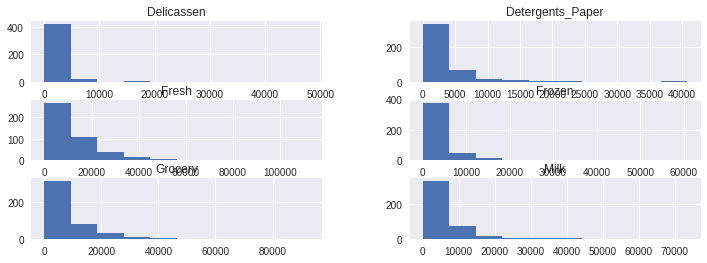

In [6]:
# Check the distrubtuion using histogram
dataset[dataset.columns].hist(figsize=(12, 4))

Note: As we can see that, all the features are prominently skewed right (their tail is longer on the right).


Let's plot kernel density plots to check the smoothness


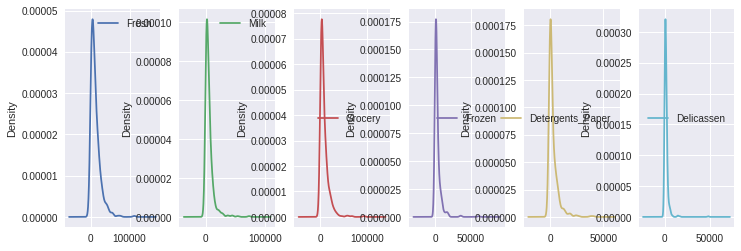

In [7]:
# Density Plot
dataset[dataset.columns].plot(kind='density', subplots=True, layout=(1, 6), sharex=False, figsize=(12, 4)); 

Or we can use seaborn's distplot.

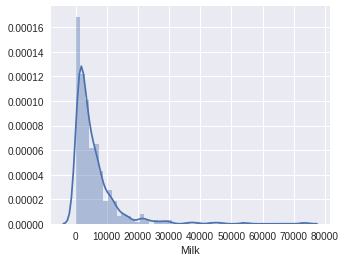

In [10]:
sns.distplot(dataset[dataset.columns[1]]);

# Visual Data Analysis - Multivariative

Let's look at the correlation among the numerical variables in our dataset.

First, we will use the method corr() on a DataFrame that calculates the correlation between each pair of features.

Then, we pass the resulting correlation matrix to heatmap() from seaborn, 
which renders a color-coded matrix for the provided values:

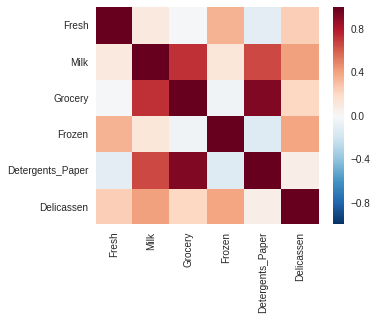

In [11]:
# Calculate and plot
corr_matrix = dataset[dataset.columns].corr()
sns.heatmap(corr_matrix);

I don't see any correlation, because no feature have been calculated directly from the other feature.

# Data Preprocessing

As dataset is not normally distributed, so I'm going to use natural logarithm to reduce skewness.

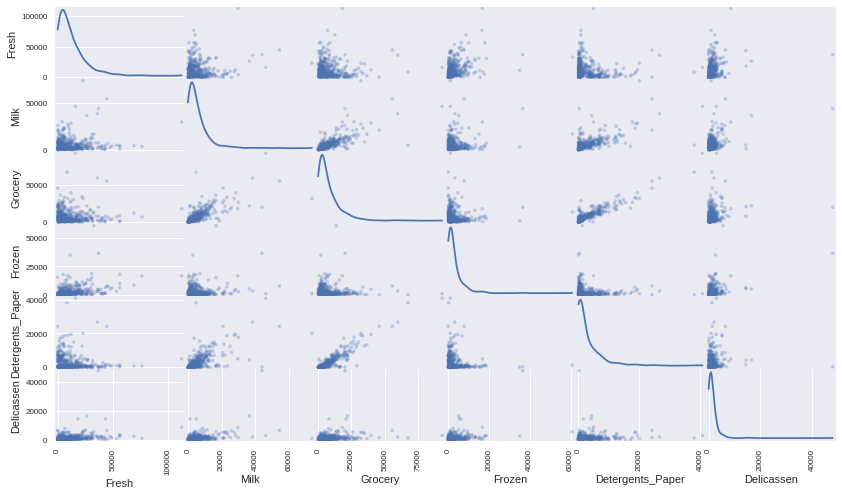

In [16]:
# Scatter matrix on the orignial dataframe
pd.scatter_matrix(dataset, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [0]:
# Applying natural logarithm
log_data = dataset.apply(lambda x: np.log(x))

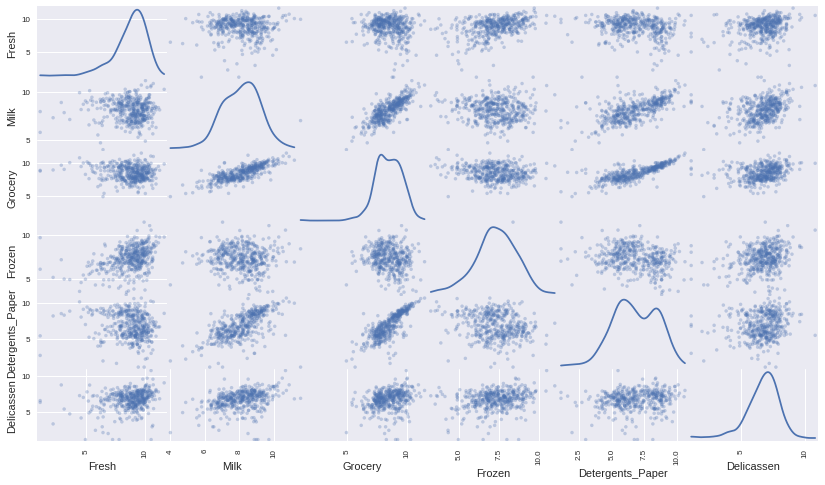

In [17]:
# Checking the scatter matrix again on log_data
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Now the distributin looks much normal.

## Outliers

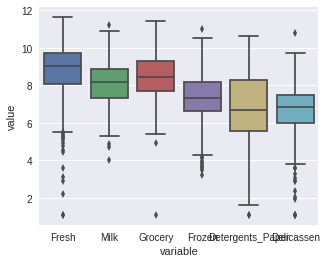

In [18]:
# Checking outliers
sns.boxplot(x="variable", y="value", data=pd.melt(log_data))

Outliers found. Fresh and Delicassen have more outliers than the others.

Let's fix the outliers from every feature.

In [0]:
outliers = []
for feature in log_data.keys():
    # Calculate 25th percentile for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate 75th percentile for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Calculate an outlier step using interquartile range
    step = (Q3-Q1)*1.5
    
    out = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    outliers = outliers + list(out.index.values)
    
#Creating list of more outliers which are the same for multiple features.
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

# Remove the outliers, if any were specified 
final_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

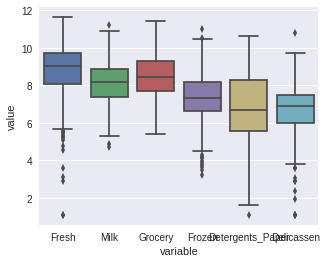

In [20]:
# Check again the outliers
sns.boxplot(x="variable", y="value", data=pd.melt(final_data))

There were five rows for more than one feature. So, I removed those 5 and tried not to lose information.


## Dimensionality Reduction

Now the dataset is scaled to a more normal distribution. 

Checking which features best maximize the variance.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
final_data = pca.fit_transform(final_data)
pca.explained_variance_ratio_

array([0.44302505, 0.26379218, 0.1230638 , 0.10120908, 0.04850196,
       0.02040793])

First two *Fresh* and *Milk* have over 70% variance together. So, I'm going to choose them.

In [0]:
# Selecting two feature
pca1 = PCA(n_components = 2)
final_data = pca1.fit_transform(final_data)

## Applying Kmeans

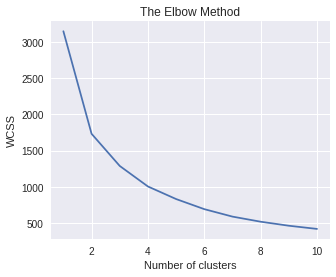

In [29]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Well, the elbow method gives 2 clusters.

In [0]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(final_data)

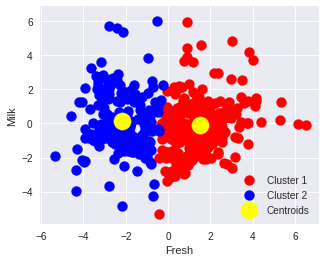

In [31]:
# Visualising the clusters
plt.scatter(final_data[y_kmeans == 0, 0], final_data[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(final_data[y_kmeans == 1, 0], final_data[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.xlabel('Fresh')
plt.ylabel('Milk')
plt.legend()
plt.show()